# Gaussian Discriminant Analysis (GDA) from Scratch  

This notebook implements **Gaussian Discriminant Analysis (GDA)** in two flavors:  
- **Linear Discriminant Analysis (LDA)** — assumes classes share a common covariance matrix.  
- **Quadratic Discriminant Analysis (QDA)** — allows separate covariance matrices for each class.  

As taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 5)** by Andrew Ng.  

It includes:  
- Feature normalization using **Z-score**  
- Parameter estimation (φ, μ₀, μ₁, Σ or Σ₀/Σ₁) from data  
- Inference using both **LDA** and **QDA** discriminants  
- **Model persistence**: save and load with Python’s `pickle` module  
- Decision boundary visualization with **contours** for LDA/QDA  
- Training diagnostics (accuracy, class distributions, etc.)  

> 📘 This is part of a broader `ml-from-scratch` project implementing foundational machine learning algorithms using only **NumPy** and **pandas** for educational and intuitive understanding.
  


In [1]:
import pickle
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from typing import Literal
import matplotlib.pyplot as plt

In [ ]:

Mode = Literal["linear", "quadratic"]

class GDA:
    def __init__(self, mode: Mode = "linear"):
        if mode not in ("linear", "quadratic"):
            raise ValueError("mode must be 'linear' or 'quadratic'")
        self.mode: str = mode
        self.to_norm: bool = False
        self.is_norm: bool = False

        # Stats
        self.x_mean: NDArray | None = None
        self.x_std: NDArray | None = None
        self.phi: float | None = None
        self.mu0: NDArray | None = None
        self.mu1: NDArray | None = None
        self.sigma_reg: NDArray | None = None

        # Linear params
        self.theta: NDArray | None = None
        self.theta0: float | None = None

        # Quadratic params
        self.A: NDArray | None = None
        self.beta: NDArray | None = None
        self.gamma: float | None = None

        self.is_fitted: bool = False

    def normalize(self, x_train: NDArray):
        self.x_mean = x_train.mean(axis=0)
        self.x_std = x_train.std(axis=0)
        self.x_std[self.x_std == 0] = 1  
        x_norm = (x_train - self.x_mean) / self.x_std
        self.is_norm = True
        return x_norm

    @staticmethod
    def sigmoid(z: NDArray):
        return 1 / (1 + np.exp(-z))

    def fit(self, x_train: NDArray, y_train: NDArray, norm: bool = False, eps: float = 1e-8):
        print("Fitting GDA model...")
        X = x_train.copy()
        if norm:
            x_train = self.normalize(x_train)
        else:
            print("No normalization used")

        y = y_train.flatten()
        y1 = (y == 1)
        y0 = ~y1

        m1, m0 = y1.sum(), y0.sum()
        m = len(y)
        self.phi = m1 / m

        self.mu0 = x_train[y0].mean(axis=0)
        self.mu1 = x_train[y1].mean(axis=0)

        print(f"Class distribution: 0 = {m0}, 1 = {m1}")
        print(f"phi = {self.phi:.3f}")
        print("mu0:", self.mu0)
        print("mu1:", self.mu1)

        if self.mode == "linear":
            centered = x_train.copy()
            centered[y0] -= self.mu0
            centered[y1] -= self.mu1
            sigma = (centered.T @ centered) / m
            self.sigma_reg = sigma + eps * np.eye(sigma.shape[0])

            sigma_inv = np.linalg.pinv(self.sigma_reg)
            self.theta = sigma_inv @ (self.mu1 - self.mu0)
            self.theta0 = (
                -0.5 * self.mu1.T @ sigma_inv @ self.mu1
                + 0.5 * self.mu0.T @ sigma_inv @ self.mu0
                + np.log(self.phi / (1 - self.phi))
            )
            self.is_fitted = True
            preds = self.predict(X)
            acc = (preds == y).mean()
            print(f"Training Accuracy (LDA): {acc*100:.2f}%")

        elif self.mode == "quadratic":
            x0, x1 = x_train[y0], x_train[y1]
            sigma0 = (x0 - self.mu0).T @ (x0 - self.mu0) / m0
            sigma1 = (x1 - self.mu1).T @ (x1 - self.mu1) / m1
            sigma0 += eps * np.eye(sigma0.shape[0])
            sigma1 += eps * np.eye(sigma1.shape[0])

            sigma0_inv, sigma1_inv = np.linalg.pinv(sigma0), np.linalg.pinv(sigma1)
            self.A = sigma1_inv - sigma0_inv
            self.beta = sigma1_inv @ self.mu1 - sigma0_inv @ self.mu0
            self.gamma = (
                -0.5 * (self.mu1.T @ sigma1_inv @ self.mu1 - self.mu0.T @ sigma0_inv @ self.mu0)
                -0.5 * np.log(np.linalg.det(sigma1) / np.linalg.det(sigma0))
                + np.log(self.phi / (1 - self.phi))
            )
            self.is_fitted = True
            preds = self.predict(X)
            acc = (preds == y).mean()
            print(f"Training Accuracy (QDA): {acc*100:.2f}%")

    def predict(self, X: NDArray):
        if not self.is_fitted:
            raise RuntimeError("Model not fitted yet!")
        if self.is_norm:
            X = (X - self.x_mean) / self.x_std

        if self.mode == "linear":
            z = X @ self.theta + self.theta0
        else:
            z = np.array([-0.5 * x.T @ self.A @ x + self.beta.T @ x + self.gamma for x in X])

        probs = self.sigmoid(z)
        return (probs >= 0.5).astype(int)

    def plot_decision_boundary(self, X, y, title="Decision Boundary"):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = self.predict(grid).reshape(xx.shape)

        plt.contourf(xx, yy, probs, alpha=0.3, cmap=plt.cm.coolwarm)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
        plt.title(title)
        plt.show()

    def save(self, filepath):
        if self.is_fitted:
            data = {
                'mode' : self.mode,
                'is_fitted': self.is_fitted,
                'is_norm' : self.is_norm,
                'x_mean': self.x_mean,
                'x_std' : self.x_std,
                'theta0' : self.theta0,
                'theta' : self.theta,
                'A' : self.A,
                'beta' : self.beta,
                'gamma' : self.gamma
                }
            with open(filepath,'wb') as f:
                pickle.dump(data, f)

    class Loader:
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)

            mode = data.get('mode')
            self.model = GDA(mode=mode)
            self.model.is_norm = data.get('is_norm')
            self.model.x_mean = data.get('x_mean')
            self.model.x_std = data.get('x_std')
            self.model.is_fitted = data.get('is_fitted')
            self.model.theta0 = data.get('theta0')
            self.model.theta = data.get('theta')
            self.model.A = data.get('A')
            self.model.beta = data.get('beta')
            self.model.gamma = data.get('gamma')

        def predict(self, x:NDArray):
            return self.model.predict(x)

In [27]:
data=pd.read_csv("./data/ds1_train.csv")
print(data.isnull().sum())
print(data.head())
print(data.tail())

x_1    0
x_2    0
y      0
dtype: int64
        x_1         x_2    y
0  2.911809   60.359613  0.0
1  3.774746  344.149284  0.0
2  2.615488  178.222087  0.0
3  2.013694   15.259472  0.0
4  2.757625   66.194174  0.0
          x_1        x_2    y
795  3.724697  23.219963  1.0
796  3.139055   5.970538  1.0
797  2.969095  20.249978  1.0
798  3.957531  27.261970  1.0
799  4.025334  12.233165  1.0


In [5]:
x_train = data[["x_1", "x_2"]].values
y_train = data[["y"]].values

Fitting GDA model...
Class distribution: 0 = 400, 1 = 400
phi = 0.500
mu0: [-0.48457544  0.32437678]
mu1: [ 0.48457544 -0.32437678]
Training Accuracy (LDA): 86.62%


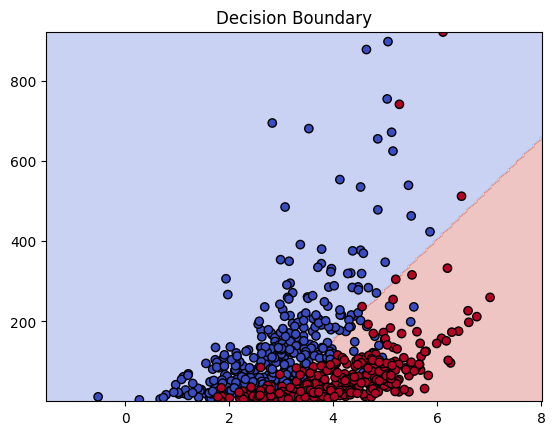

In [31]:
model = GDA()
model.fit(x_train, y_train, norm=True, eps=1e-8)
model.plot_decision_boundary(x_train, y_train)


Fitting GDA model...
Class distribution: 0 = 400, 1 = 400
phi = 0.500
mu0: [-0.48457544  0.32437678]
mu1: [ 0.48457544 -0.32437678]
Training Accuracy (QDA): 85.25%


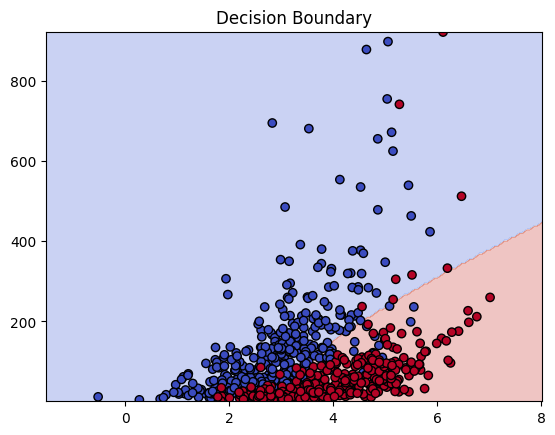

In [33]:
Model=GDA(mode='quadratic')
Model.fit(x_train, y_train, norm=True, eps=1e-6)
Model.plot_decision_boundary(x_train, y_train)